# Eigenfaces

El objetivo de este cuaderno de Jupyter consiste en dar una implementación sencilla del método de **eigenfaces**, también conocido como autocaras, para el reconocimiento de rostros humanos.

## Importaciones y análisis exploratorio

En primer lugar, importaremos los paquetes necesarios para realizar nuestra labor, así como el conjunto de imágenes de caras que se empleará como muestra. Este conjunto de imágenes, conocido como el [dataset de Olivetti](https://scikit-learn.org/0.19/datasets/olivetti_faces.html), fue obtenido entre abril de 1992 y abril de 1994 en los laboratorios AT&T de Cambridge. En él, hay 10 imágenes distintas de 40 personas diferentes, las cuales han sido tomadas bajo varias condiciones de iluminación, expresión facial y detalles faciales. No obstante, todas las imágenes se tomaron sobre un fondo oscuro y homogéneo, con los sujetos en posición vertical y frontal (con tolerancia para algún movimiento lateral).

La obtención del dataset se obtendría habitualmente del propio scikitlearn pero, debido a que pertenece a una versión antigua del mismo, se ha descargado de la [página de Github](https://github.com/daradecic/Python-Eigenfaces) empleada como guía a la hora de realizar esta implementación.

In [1]:
# Importación de los paquetes y funciones a utilizar
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargamos los datos y vemos una vista preliminar de los mismos
datos = pd.read_csv('face_data.csv')
datos.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [3]:
datos.shape

(400, 4097)

Los datos se organizan en columans, donde cada una representa un valor normalizado de píxel (entre 0 y 1). Como hay 4096 columnas (descontando la última), las imágenes se encuentran almacenadas en un formato de 64x64 a un único canal de color (grises).

Al final se encuentra la columna *target*, que permite identificar a qué persona pertenece cada imagen. Si consultamos los valores no repetidos de dicha columna, comprobamos que en efecto tenemos imágenes de 40 personas diferentes:

In [4]:
datos['target'].nunique()

40

Tras comprender mejor cuál es la estructura de los datos que tenemos, procederemos a separar las etiquetas de los datos de los propios píxeles de las imágenes. Además, también será conveniente visualizar algunas de las imágenes guardadas, para verificar que dicha información se adecúa a la muestra de datos que estamos buscando.

In [5]:
# Realizamos la distinción entre los datos de imágenes y las etiquetas
caras = datos.drop('target', axis=1)
labels = datos['target']

In [6]:
# Función para la visualización de imágenes
def showImgs(caras, n_imgs, i_imgs):
    # caras -> Imágenes 64x64 guardadas como píxeles
    # n_imgs -> Nº de imágenes a mostrar
    # i_imgs -> Rango de las imágenes a mostrar
    n = sqrt(n_imgs)
    m = n
    p = 1
    if n != int(n):
        n = int(n)
        m = n + 1
    print("n, m", n, m)
    fig = plt.figure()
    for i in i_imgs:
        fig.add_subplot(int(n), int(m), p)
        plt.imshow(np.array(caras)[i].reshape(64, 64), cmap='gray')
        plt.axis('off')
        p += 1
plt.show()

n, m 4 5


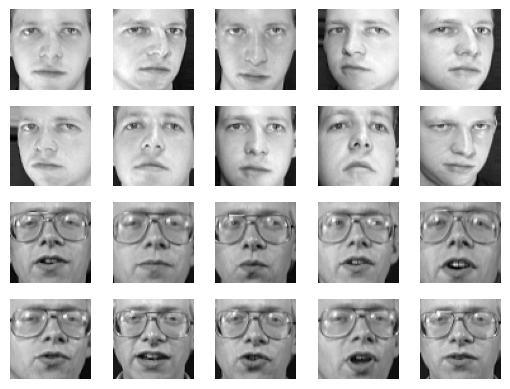

In [7]:
# Mostramos todas las imágenes de los dos primeros integrantes del dataset
showImgs(caras, 20, range(20))

## Análisis de Componentes Principales

Tal y como se ha comentado en el propio Trabajo Fin de Grado, para poder aplicar el método de eigenfaces es necesario reducir la dimensionalidad del problema, preservando únicamente las componentes que den la mayor varianza. Para ello, aplicaremos PCA.

No obstante, al igual que se hace en toda área de Aprendizaje Automático, primero es necesario dividir los datos en un conjunto de entrenamiento y otro de test para poder entrenar, probar y validar modelos.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(caras, labels, stratify=labels)

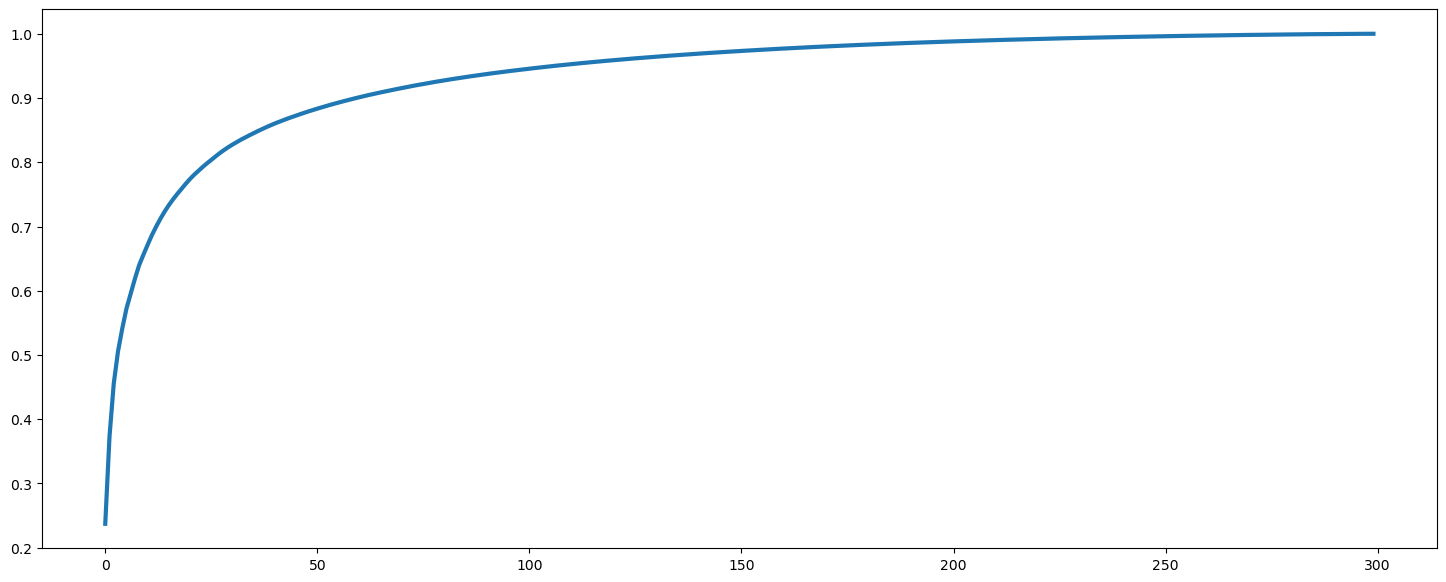

In [19]:
# Realizamos el cálculo de las componentes principales
pca = PCA().fit(X_train)

plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

Tras calcular las componentes principales, es necesario determinar cuántas de ellas escogeremos para el cálculo de las eigenfaces. Es por ello que hemos mostrado un gráfico resumen de la suma cumulativa. Para poder alcanzar un **p-valor** de 0.05, lo cual nos daría resultados bastante precisos, vemos que serían necesarias aproximadamente 100 componentes principales. Verifiquemos dicha cantidad de manera precisa:

In [20]:
np.where(pca.explained_variance_ratio_.cumsum() > 0.95)

(array([106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
        223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
        236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
        249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261,
        262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274,
        275, 276, 277, 278, 279, 280, 281, 282, 283

Efectivamente, con 106 componentes principales podemos alcanzar una razón de verosimilitud del 95%, por lo que emplearemos este valor para volver a ejecutar PCA y quedarnos únicamnente con esa cantidad de componentes.

In [21]:
pca = PCA(n_components=106).fit(X_train)

In [22]:
# Reducimos la dimensionalidad de los datos de entrenamiento
X_train_pca = pca.transform(X_train)

In [23]:
pca.components_.shape

(106, 4096)

Hemos obtenido por lo tanto las autocaras buscadas. En concreto, tenemos 106 eigenfaces distintas, las cuales siguen siendo imágenes de tamaño 64x64. Por lo tanto, podrán seguir visualizándose. Veamos las 25 primeras (aquellas que ofrecen mayor varianza):

n, m 5.0 5.0


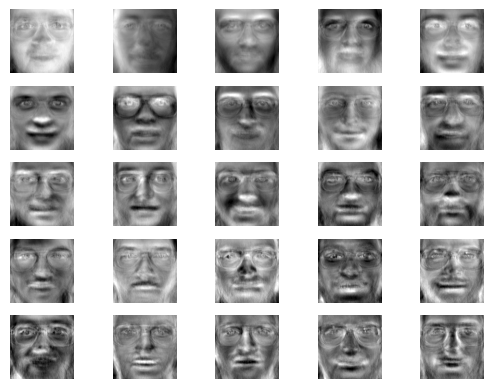

In [24]:
best_eigenfaces = []
for eigenface in pca.components_[0 : 25]:
    best_eigenfaces.append(eigenface.reshape(64, 64))
showImgs(best_eigenfaces, 25, range(25))

## Entrenamiento del modelo y evaluación

Una vez reducida la dimensionalidad de los datos, entrenaremos un clasificador (en este caso escogeremos una **máquina de vectores de soporte**, el cual es un método de clasificación de discriminante lineal como de los que se han hablado en el trabajo) para poder identificar rostros.

In [25]:
clasificador = SVC().fit(X_train_pca, y_train)

Tras haber entrenado el modelo, ha llegado el momento de probarlo gracias a los datos de prueba que hemos apartado anteriormente. Una vez reducida también su dimensionalidad, el propio clasificador tiene una función para predecir la clase (en este caso, de quién es la cara) de cada dato de entrada que le proporcionamos.

In [26]:
X_test_pca = pca.transform(X_test)
predicciones = clasificador.predict(X_test_pca)

Consultemos ahora las estadísticas sobre los resultados obtenidos tras haber testado nuestro reconocedor de rostros con los datos de prueba:

In [27]:
print(classification_report(y_test, predicciones))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

El modelo obtenido identifica correctamente un rostro el 93% de las veces (***accuracy***), lo cual se corresponde con el p-valor escogido cuando realizamos la elección del número de componentes principales a considerar. Si bien no alcanza la razón de verosimilitud pedida, la pequeña cantidad de datos de cada cara de los que se dipone impide obtener mejores resultados. En general, todas las caras se suelen reconocer al menos la mitad de las veces. Para mejorar la precisión y fiabilidad del modelo, sería necesario disponer de una mayor cantidad de datos etiquetados tanto para el entrenamiento como para la prueba del modelo.

Como último apunte, estos resultados han sido tan precisos gracias a que todas las fotos fueron tomadas bajo las mismas condiciones, pero bajo otras condiciones (iluminación, ángulo, pose...) el reconocimiento de rostros no funcionaría igual de bien.